# NN FM biomes : neural-network with Fay & McKinley biomes
- **target**: spco2
- **features**: [sst, sss, chl, mld, xco2, T0, T1, biomes]


In [2]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import scipy.stats
#import seaborn as sns

# Plotting packages
import matplotlib.pyplot as plt
from plotting_tools.spatial_map import SpatialMap
from plotting_tools.time_series_diagram import TimeSeriesPlot
import cmocean as cm

# Modeling
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# one hot encoder
from sklearn.preprocessing import OneHotEncoder

pd.set_option("display.max_columns", 100)

# Define useful functions

### Repeaters

In [3]:
def repeat_time(ds=None, dates=None):
    ''' 
    dates needs to be a pandas date_range
    Example
    dates = pd.date_range(start='1982-01-01T00:00:00.000000000', 
                      end='2017-12-01T00:00:00.000000000',freq='MS')+ np.timedelta64(14, 'D')
    '''
    ds_bc = xr.DataArray(np.zeros([len(dates)]), coords=[('time', dates)])
    ds_data, ds_mask = xr.broadcast(ds, ds_bc)
    return ds_data

def repeat_lat(ds=None):
    lat = np.arange(-89.5,90,1)
    ds_bc = xr.DataArray(np.zeros([len(lat)]), coords=[('lat', lat)])
    ds_data, ds_mask = xr.broadcast(ds, ds_bc)
    return ds_data

def repeat_lon(ds=None):
    lon = np.arange(0.5,360,1)
    ds_bc = xr.DataArray(np.zeros([len(lon)]), coords=[('lon', lon)])
    ds_data, ds_mask = xr.broadcast(ds, ds_bc)
    return ds_data

def repeat_lat_and_lon(ds=None):
    lon = np.arange(0.5,360,1)
    lat = np.arange(-89.5,90,1)
    ds_bc = xr.DataArray(np.zeros([len(lon),len(lat)]), coords=[('lon', lon),('lat', lat)])
    ds_data, ds_mask = xr.broadcast(ds, ds_bc)
    return ds_data

def repeat_time_and_lon(ds=None, dates=None):
    ''' dates needs to be a pandas date_range
    Example
    dates = pd.date_range(start='1998-01-01T00:00:00.000000000', 
                      end='2017-12-01T00:00:00.000000000',freq='MS')+ np.timedelta64(14, 'D')
    '''
    lon = np.arange(0.5,360,1)
    ds_bc = xr.DataArray(np.zeros([len(dates), len(lon), ]), coords=[('time', dates),('lon', lon)])
    ds_data, ds_mask = xr.broadcast(ds, ds_bc)
    return ds_data

def repeat_time_and_lat(ds=None, dates=None):
    ''' dates needs to be a pandas date_range
    Example
    dates = pd.date_range(start='1998-01-01T00:00:00.000000000', 
                      end='2017-12-01T00:00:00.000000000',freq='MS')+ np.timedelta64(14, 'D')
    '''
    lat = np.arange(-89.5,90,1)
    ds_bc = xr.DataArray(np.zeros([len(dates), len(lat), ]), coords=[('time', dates),('lat', lat)])
    ds_data, ds_mask = xr.broadcast(ds, ds_bc)
    return ds_data

### Tranformations

In [4]:
import numpy as np

# Define functions
def transform_doy(obj, dim='time'):
    '''
    transform_doy(ds, dim='time')
    transform DOY into repeating cycles
    
    reference
    ==========
    Gregor et al. 2019 
    '''
    obj['T0'] = np.cos(obj[f'{dim}.dayofyear'] * 2 * np.pi / 365)
    obj['T1'] = np.sin(obj[f'{dim}.dayofyear'] * 2 * np.pi / 365)
    return obj[['T0','T1']]

def compute_n_vector(obj, dim_lon='lon', dim_lat='lat'):
    '''
    compute_n_vector(ds,dim_lon='lon', dim_lat='lat')
    calculate n-vector from lat/lon
    
    reference
    ==========
    Gregor et al. 2019 
    '''
    ### convert lat/lon to radians
    obj['lat_rad'], obj['lon_rad'] = np.radians(obj[dim_lat]), np.radians(obj[dim_lon])

    ### Calculate n-vector
    obj['A'], obj['B'], obj['C'] = np.sin(obj['lat_rad']), \
                            np.sin(obj['lon_rad'])*np.cos(obj['lat_rad']), \
                            -np.cos(obj['lon_rad'])*np.cos(obj['lat_rad'])
    return obj[['A','B','C']]

### mask generators

In [5]:
import xarray as xr
from skimage.filters import sobel

def network_mask(dir_obs='/local/data/artemis/observations'):
    '''network_mask
    This masks out regions in the 
    NCEP land-sea mask (https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.surface.html)
    to define the open ocean. Regions removed include:
    - Coast : defined by sobel filter
    - Batymetry less than 100m
    - Arctic ocean : defined as North of 79N
    - Hudson Bay
    - caspian sea, black sea, mediterranean sea, baltic sea, Java sea, Red sea
    '''
    ### topography
    ds_topo = xr.open_dataset(f'{dir_obs}/GEBCO_2014/processed/GEBCO_2014_1x1_global.nc')
    ds_topo = ds_topo.roll(lon=180, roll_coords='lon')
    ds_topo['lon'] = np.arange(0.5, 360, 1)

    ### Loads grids
    # land-sea mask
    # land=0, sea=1
    ds_lsmask = xr.open_dataset(f'{dir_obs}/masks/originals/lsmask.nc').sortby('lat').squeeze().drop('time')
    data = ds_lsmask['mask'].where(ds_lsmask['mask']==1)
    ### Define Latitude and Longitude
    lon = ds_lsmask['lon']
    lat = ds_lsmask['lat']
    
    ### Remove coastal points, defined by sobel edge detection
    coast = (sobel(ds_lsmask['mask'])>0)
    data = data.where(coast==0)
    
    ### Remove shallow sea, less than 100m
    ### This picks out the Solomon islands and Somoa
    data = data.where(ds_topo['Height']<-100)
    
    ### remove arctic
    data = data.where(~((lat>79)))
    data = data.where(~((lat>67) & (lat<80) & (lon>20) & (lon<180)))
    data = data.where(~((lat>67) & (lat<80) & (lon>-180+360) & (lon<-100+360)))

    ### remove caspian sea, black sea, mediterranean sea, and baltic sea
    data = data.where(~((lat>24) & (lat<70) & (lon>14) & (lon<70)))
    
    ### remove hudson bay
    data = data.where(~((lat>50) & (lat<70) & (lon>-100+360) & (lon<-70+360)))
    data = data.where(~((lat>70) & (lat<80) & (lon>-130+360) & (lon<-80+360)))
    
    ### Remove Red sea
    data = data.where(~((lat>10) & (lat<25) & (lon>10) & (lon<45)))
    data = data.where(~((lat>20) & (lat<50) & (lon>0) & (lon<20)))
    
    return data

### one-hot-encoder

In [6]:
def one_hot_encoder(ds=None):
    '''
    one_hot_encode(ds)
        one-hot-encoder.
        
    input
    --------
    ds : Numpy array
        can not have any NaN values. (use .fillna(0))
        needs to be row-wise. (either .transpose() or .reshape(-1, 1))

    output
    ---------
    df : dataframe
        dataframe with encoded regions. The first column is the fill value
    
    example:
    -----------
    df_onehot = one_hot_encoder(ds_tmp['MeanBiomesGrouped'].fillna(0).values.reshape(-1, 1))
    
    Alternatives
    -------------
    you can also use pandas for one-hot-encoding:
    oneHotLabels = pd.get_dummies(ds_tmp['MeanBiomesGrouped'] )
    '''
    # -----------------------------------------------------
    # Sklearn version of OneHotEncoder
    # -----------------------------------------------------
    # 1. INSTANTIATE
    enc = OneHotEncoder(categories='auto')

    # 2. FIT
    enc.fit(ds)

    # 3. Transform
    onehotlabels = enc.transform(ds).toarray()
    #print(onehotlabels.shape)

    # Dataframe of one-hot-labels
    df_onehot = pd.DataFrame(onehotlabels)
    
    return df_onehot

### Define biomes

In [7]:
def group_fay_mckinley_biomes(dir_obs='/local/data/artemis/observations'):
    # Load Fay and McKinley Biomes 
    ds = xr.open_dataset(f'{dir_obs}/Biomes_FayMcKinley/originals/Time_Varying_Biomes.nc')

    # Variable Name
    VAR = 'MeanBiomes'

    # Define grouped regions
    # and assign a number to it
    # ------------------------------------------------------
    # Northern Hemisphere - High Latitudes
    # ------------------------------------------------------
    ds_NH_HL= ds[VAR].where((ds[VAR]==1) | # NPICE
                                (ds[VAR]==8) |     #NAICE
                               (ds[VAR]==2) |      #NPSPSS
                               (ds[VAR]==9) | #NASPAA
                               (ds[VAR]==3) | # NPSTSS
                               (ds[VAR]==10) # NASTSS
                              )
    ds_NH_HL = (ds_NH_HL>0).where(ds_NH_HL>0) * 1
    # ------------------------------------------------------
    # Nothern Hemisphere - SubTropics
    # ------------------------------------------------------
    ds_NH_ST=ds[VAR].where((ds[VAR]==4) | # NP STPS
                                (ds[VAR]==11) # NA STPS
                              )
    ds_NH_ST = (ds_NH_ST>0).where(ds_NH_ST>0) * 2

    # ------------------------------------------------------
    # Equatorial Regions
    # ------------------------------------------------------
    ds_EQU=ds[VAR].where((ds[VAR]==5) | # PEQU-W
                                (ds[VAR]==6) | # PEQU-E
                                (ds[VAR]==12) # AEQU
                              )
    ds_EQU = (ds_EQU>0).where(ds_EQU>0) * 3

    # ------------------------------------------------------
    # Equatorial Regions
    # ------------------------------------------------------
    ds_SH_ST=ds[VAR].where((ds[VAR]==7) | # SP STPS
                                (ds[VAR]==13) | # SA STPS
                                (ds[VAR]==14) # IND STPS
                              )
    ds_SH_ST = (ds_SH_ST>0).where(ds_SH_ST>0) * 4

    # ------------------------------------------------------
    # Equatorial Regions
    # ------------------------------------------------------
    ds_SH_HL=ds[VAR].where((ds[VAR]==15) | # SO STSS
                                (ds[VAR]==16) | # SO SPSS
                                (ds[VAR]==17) # SO ICE
                              )
    ds_SH_HL = (ds_SH_HL>0).where(ds_SH_HL>0) * 5

    # Group all the regions together
    ds_grouped = xr.concat([ds_NH_HL, ds_NH_ST, ds_EQU, ds_SH_ST, ds_SH_HL], 
                           dim='regions').sum('regions').transpose()

    # Put into xarray dataset
    ds_out = xr.Dataset(
        {
        'MeanBiomes':(['lat', 'lon'],
                      ds[VAR].transpose().roll(lon=180, roll_coords='lon')),
        'MeanBiomesGrouped':(['lat', 'lon'], 
                             ds_grouped.roll(lon=180, roll_coords='lon').where(ds_grouped >0)),
        },

        coords={
        'lat': (['lat'], np.arange(-89.5, 90, 1)),
        'lon': (['lon'], np.arange(0.5, 360, 1)),
        })

    return ds_out

In [8]:
# Data directory
# This is pre-processed data
dir_obs = '/local/data/artemis/observations'
dir_data = '/local/data/artemis/observations/neural_net_data'

## Load Fay McKinley biomes

### Test plot

In [9]:
#plt.pcolor(ds_test['lon'], ds_test['lat'], ds_test['biome2'].sel(time='1998-01-01',method='nearest'))

## Load data

### Classic predictors

In [10]:
# Observations dictionary
dict_data = {'spco2': f'{dir_data}/spco2_1x1_mon_SOCATv2019_199801-201712.nc', 
             'sst': f'{dir_data}/sst_1x1_mon_NOAAOIv2_199801-201712.nc',
             'sss': f'{dir_data}/sss_1x1_mon_EN421_199801-201712.nc',
             'chl': f'{dir_data}/chl_1x1_mon_globColour_199801-201712.nc',
             'mld': f'{dir_data}/mld_1x1_clim_deBoyer_199801-201712.nc',
             'xco2': f'{dir_data}/xco2_1x1_mon_globalview_199801-201712.nc'}

###  Load all variables into common dataset
ds = xr.merge([xr.open_dataset(dict_data['sst']),
               xr.open_dataset(dict_data['sss']),
               xr.open_dataset(dict_data['chl']),
               xr.open_dataset(dict_data['mld']),
               xr.open_dataset(dict_data['xco2']),
               xr.open_dataset(dict_data['spco2'])])

### Biome predictors

In [11]:
#ds_out

In [12]:
# ---------------------------------
# Load data
# ---------------------------------
# Load group the biomes
ds_out = group_fay_mckinley_biomes()

# Convert grouped biomes to dataframe
df_tmp = ds_out['MeanBiomesGrouped'].to_dataframe().reset_index()

# ---------------------------------
# one-hot encode
# ---------------------------------
# encode the biomes
df_onehot = one_hot_encoder(df_tmp['MeanBiomesGrouped'].fillna(0).values.reshape(-1, 1))

# ---------------------------------
# Rename the columns
# ---------------------------------
# list of biome names
biome_num = np.arange(1,6,1)
string_list = [",".join(item) for item in biome_num.astype(str)]
column_names = ['biome' + s for s in string_list]

# add mask to beginning of column names
column_names.insert(0,'biomeNull')

# rename the colums in dataframe
df_onehot.columns = column_names


# ---------------------------------
# Put the one-hot-encoded data into dataset
# ---------------------------------
# Latitude, longitude vectors
lon = ds_out['lon']
lat = ds_out['lat']

# Make predictions - to final dataframe to be aware of coords
df_all = ds_out.to_dataframe().reset_index()

# Put preidctionsinto dataframe
df_all = pd.concat([df_all, df_onehot], axis=1)

# Reshape output to (lat, lon, time)
dim_lat, dim_lon = ds_out['MeanBiomes'].shape

# Put into xarray dataset
ds_fm_groups = xr.Dataset(
    {
    'biomeNull':(['lat', 'lon'], df_all['biomeNull'].values.reshape(dim_lat, dim_lon)),
    'biome1':(['lat', 'lon'], df_all['biome1'].values.reshape(dim_lat, dim_lon)),
    'biome2':(['lat', 'lon'], df_all['biome2'].values.reshape(dim_lat, dim_lon)),
    'biome3':(['lat', 'lon'], df_all['biome3'].values.reshape(dim_lat, dim_lon)),
    'biome4':(['lat', 'lon'], df_all['biome4'].values.reshape(dim_lat, dim_lon)),
    'biome5':(['lat', 'lon'], df_all['biome5'].values.reshape(dim_lat, dim_lon)),
    },

    coords={
    'lat': (['lat'], lat),
    'lon': (['lon'], lon),
    })

# ---------------------------------
# repeat over time
# so easier for NN to ingest
# ---------------------------------
# Create a date vector
dates = pd.date_range(start='1998-01-01T00:00:00.000000000', 
                      end='2017-12-01T00:00:00.000000000',freq='MS')+ np.timedelta64(14, 'D')

# final output
#ds_fm_groups = repeat_time(ds_fm_groups, dates=dates).transpose('time', 'lat', 'lon')

### Merge predictors

In [13]:
# Create a date vector
dates = pd.date_range(start='1998-01-01T00:00:00.000000000', 
                      end='2017-12-01T00:00:00.000000000',freq='MS')+ np.timedelta64(14, 'D')

ds  = xr.merge([ds, # Standard variables
                #detrend(ds['SST'], dim='time').rename('SST_detrend'),
                repeat_lat_and_lon( transform_doy(ds) ),                       # DOY transofrmation     
                repeat_time_and_lon( compute_n_vector(ds)['A'] , dates=dates), # n-vector
                repeat_time( compute_n_vector(ds)[['B','C']], dates=dates),    # n-vector
                repeat_time(ds_fm_groups, dates=dates)                        # biomes 
               ])                         

In [14]:
ds = ds.transpose('time','lat','lon').drop(['lat_rad','lon_rad'])

In [15]:
ds

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, time: 240)
Coordinates:
  * lat        (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time       (time) datetime64[ns] 1998-01-15 1998-02-15 ... 2017-12-15
Data variables:
    sst        (time, lat, lon) float32 ...
    sss        (time, lat, lon) float32 ...
    chl        (time, lat, lon) float32 ...
    mld        (time, lat, lon) float32 ...
    xco2       (time, lat, lon) float64 ...
    spco2      (time, lat, lon) float32 ...
    T0         (time, lat, lon) float64 0.9668 0.9668 0.9668 ... 0.9623 0.9623
    T1         (time, lat, lon) float64 0.2554 0.2554 0.2554 ... -0.272 -0.272
    A          (time, lat, lon) float32 -0.9999619 -0.9999619 ... 0.9999619
    B          (time, lat, lon) float32 7.6152646e-05 ... -7.615485e-05
    C          (time, lat, lon) float32 -0.008726229 ... -0.008726229
    biomeNull  (time, lat, lon) float64

## Mask data

In [16]:
# Define my network mask
mask = network_mask()

In [17]:
# Apply mask to dataset
ds = ds.where(mask==1)

## Put into dataframe

In [18]:
# Input features
#features = ['sst', 'sss', 'chl', 'mld', 'xco2', 'A', 'B', 'C', 'T0', 'T1']
features = ['sst', 'sss', 'chl', 'mld', 'xco2', 
            'biome1', 'biome2', 'biome3', 'biome4', 'biome5', 
            'A', 'B', 'C', 
            'T0', 'T1']


# Features with time, lat, lon included
features_plus_coords = features.copy()
features_plus_coords.extend(['time', 'lon', 'lat'])

In [19]:
### Put data into dataframe 
df = ds.to_dataframe().reset_index()

# Features with spco2
features_extended = features.copy()
features_extended.extend(['time', 'lon', 'lat', 'spco2'])

### select variables and drop nans 
df.dropna(subset=features_extended, inplace=True)

In [20]:
df.head()

,lat,lon,time,sst,sss,chl,mld,xco2,spco2,T0,T1,A,B,C,biomeNull,biome1,biome2,biome3,biome4,biome5
1162620,-76.5,164.5,2003-01-15,-0.94,34.160316,0.314534,18.729113,374.796520,278.475037,0.966848,0.255353,-0.97237,0.062386,0.224955,0.0,0.0,0.0,0.0,0.0,1.0
1162632,-76.5,164.5,2004-01-15,-0.82,34.143547,0.356009,18.729113,376.998760,213.402817,0.966848,0.255353,-0.97237,0.062386,0.224955,0.0,0.0,0.0,0.0,0.0,1.0
1162633,-76.5,164.5,2004-02-15,-0.88,33.959709,0.763949,23.885191,377.540533,199.720215,0.702527,0.711657,-0.97237,0.062386,0.224955,0.0,0.0,0.0,0.0,0.0,1.0
1162669,-76.5,164.5,2007-02-15,-0.37,33.936447,0.395035,23.885191,383.332733,190.667770,0.702527,0.711657,-0.97237,0.062386,0.224955,0.0,0.0,0.0,0.0,0.0,1.0
1162680,-76.5,164.5,2008-01-15,-0.87,33.994492,0.665366,18.729113,384.997100,201.477844,0.966848,0.255353,-0.97237,0.062386,0.224955,0.0,0.0,0.0,0.0,0.0,1.0


## Train / validation / test split

In [21]:
# Input and Output
X = df.loc[:, features] 
y = df.loc[:,'spco2']

### Uses train_test_split build into sklearn.model_selection
### By default this method shuffles the data (30% = testing 70%=training/validation)
### Train  = 49%
### Valid  = 21%
### Test   = 30%
X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.3, random_state= 73)
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.3, random_state = 28)
del X_tmp
del y_tmp

### Select features for training
X_train_ready = X_train[features]
X_train_ready = X_train_ready.values
y_train_ready = y_train.values

### Select features for validation
X_val_ready = X_val[features]
X_val_ready = X_val_ready.values
y_val_ready = y_val.values

### Select features for testing
X_test_ready = X_test[features]
X_test_ready = X_test_ready.values
y_test_ready = y_test.values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(98641, 15) (98641,)
(42275, 15) (42275,)
(60393, 15) (60393,)


In [22]:
### make sure there are no nans anywhere
print('NaNs in X_train_ready:', np.isnan(X_train_ready).sum())
print('NaNs in y_train_ready:', np.isnan(y_train_ready).sum())

print('NaNs in X_val_ready:', np.isnan(X_val_ready).sum())
print('NaNs in y_val_ready:', np.isnan(y_val_ready).sum())

print('NaNs in X_test_ready:', np.isnan(X_test_ready).sum())
print('NaNs in y_test_ready:', np.isnan(y_test_ready).sum())

NaNs in X_train_ready: 0
NaNs in y_train_ready: 0
NaNs in X_val_ready: 0
NaNs in y_val_ready: 0
NaNs in X_test_ready: 0
NaNs in y_test_ready: 0


# Neural Network model

In [23]:
def FFN_Model():
    model = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu, kernel_initializer='glorot_normal'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(512, activation=tf.nn.relu, kernel_initializer='glorot_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, kernel_initializer='normal')])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
    
    return model

In [24]:
n_epochs = 30

model = FFN_Model()
history = model.fit(X_train_ready, y_train_ready, epochs=n_epochs, 
                    batch_size=1024, validation_data=(X_val_ready, y_val_ready))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 98641 samples, validate on 42275 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
98641/98641 [==============================] - 2s 20us/sample - loss: 46308.8355 - mean_squared_error: 46308.8594 - val_loss: 1787455.0479 - val_mean_squared_error: 1787455.1250
Epoch 2/30
98641/98641 [==============================] - 2s 16us/sample - loss: 1633.0397 - mean_squared_error: 1633.0396 - val_loss: 68751.0989 - val_mean_squared_error: 68751.1094
Epoch 3/30
98641/98641 [==============================] - 2s 16us/sample - loss: 1243.0403 - mean_squared_error: 1243.0402 - val_loss: 2796.2264 - val_mean_squared_error: 2796.2266
Epoch 4/30
98641/98641 [==============================] - 2s 16us/sample - loss: 1121.3356 - mean_squared_error: 1

## Plot training process

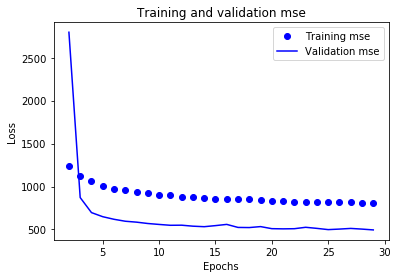

In [25]:
## training visualization
history_dict = history.history

epochs = range(n_epochs)
plt.clf() #Clears the figure 
acc_values = history_dict['mean_squared_error']
val_acc_values = history_dict['val_mean_squared_error']
plt.plot(epochs[2:], acc_values[2:], 'bo', label='Training mse')
plt.plot(epochs[2:], val_acc_values[2:], 'b', label='Validation mse')
plt.title('Training and validation mse')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('training_w\cluster_full')

## Eveluation on test-set

In [26]:
pred_test = model.predict(X_test_ready)

In [27]:
rmse = mean_squared_error(y_test_ready, pred_test) ** 0.5
r, p = scipy.stats.pearsonr(np.expand_dims(y_test_ready, axis=1), pred_test)
print(f'RMSE = {rmse} uatm')
print(f'r = {r}')
print(f'R2 = {r**2}')
print(f'p-value = {p}')

RMSE = 21.43049849791508 uatm
r = [0.80231076]
R2 = [0.64370257]
p-value = [0.]


In [30]:
rmse = mean_squared_error(y_test_ready, pred_test) ** 0.5
r, p = scipy.stats.pearsonr(np.expand_dims(y_test_ready, axis=1), pred_test)
print(f'RMSE = {rmse} uatm')
print(f'r = {r}')
print(f'R2 = {r**2}')
print(f'p-value = {p}')

RMSE = 23.37329617578774 uatm
r = [0.7582227]
R2 = [0.57490164]
p-value = [0.]


In [120]:
rmse = mean_squared_error(y_test_ready, pred_test) ** 0.5
r, p = scipy.stats.pearsonr(np.expand_dims(y_test_ready, axis=1), pred_test)
print(f'RMSE = {rmse} uatm')
print(f'r = {r}')
print(f'R2 = {r**2}')
print(f'p-value = {p}')

RMSE = 21.258098898980315 uatm
r = [0.80597913]
R2 = [0.64960235]
p-value = [0.]


(150, 550)

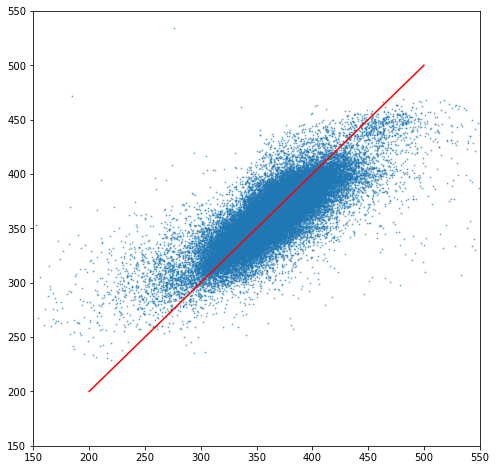

In [28]:
plt.figure(figsize=(8,8))
plt.scatter(y_test_ready, pred_test, alpha = 0.5, s =0.8)
plt.plot([200, 500], [200,500], linestyle='-', color = 'red')
plt.xlim(150,550)
plt.ylim(150,550)
# plt.savefig(figdir+'base_ontest.png')

# Put predictions back to make a map

In [29]:
# Latitude, longitude vectors
lon = ds['lon']
lat = ds['lat']
time = ds['time']

# create a time,lat,lon skeleton
skeleton_xr = ds.to_dataframe().reset_index()
skeleton_xr = skeleton_xr[['time','lat','lon']]

# Make predictions - to final dataframe to be aware of coords
df_all = ds.to_dataframe().reset_index()
df_all = df_all[features_plus_coords].dropna()

In [30]:
df_all[features].head()

,sst,sss,chl,mld,xco2,biome1,biome2,biome3,biome4,biome5,A,B,C,T0,T1
1162560,-0.24,34.151615,0.953114,18.729113,365.070320,0.0,0.0,0.0,0.0,1.0,-0.97237,0.062386,0.224955,0.966848,0.255353
1162561,-0.11,34.064667,3.332136,23.885191,365.350433,0.0,0.0,0.0,0.0,1.0,-0.97237,0.062386,0.224955,0.702527,0.711657
1162562,-1.18,34.161743,0.000000,47.545898,365.753650,0.0,0.0,0.0,0.0,1.0,-0.97237,0.062386,0.224955,0.292600,0.956235
1162563,-1.72,34.188812,0.000000,168.681793,366.391750,0.0,0.0,0.0,0.0,1.0,-0.97237,0.062386,0.224955,-0.234491,0.972118
1162564,-1.65,34.182281,0.000000,0.000000,366.712675,0.0,0.0,0.0,0.0,1.0,-0.97237,0.062386,0.224955,-0.683919,0.729558


In [31]:
y_pred = model.predict(df_all[features])

In [32]:
# Put preidctionsinto dataframe
df_all['spco2_pred'] = y_pred

# merge the predictions into skeleton on the time, lat, lon coords
output = skeleton_xr.merge(df_all[['time', 'lat', 'lon', 'spco2_pred']], 
                           how = 'left', on = ['time','lat','lon'])

# Reshape output to (lat, lon, time)
dim_time, dim_lat, dim_lon = ds['spco2'].shape
out = output['spco2_pred'].values.reshape(dim_lat, dim_lon, dim_time)

# Put into xarray dataset
ds_out = xr.Dataset(
    {
    'spco2':(['lat', 'lon', 'time'], out),
    # 'error':(['lat', 'lon', 'time'], error),
    },

    coords={
    'time': (['time'], time),
    'lat': (['lat'], lat),
    'lon': (['lon'], lon),
    })

## Test plot

/home/gloege/miniconda3/envs/tensorflow/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


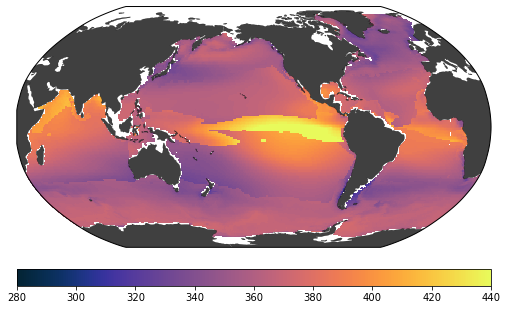

In [33]:
### Mask
dia = SpatialMap(cbar_location='bottom', cbar_orientation='horizontal')
sub = dia.add_plot(lon=ds_out['lon'], 
             lat=ds_out['lat'], 
             data=ds_out['spco2'].mean('time'), 
             ax=0, 
             cmap=cm.cm.thermal, 
             vrange=[280,440])
dia.add_colorbar(sub)
#plt.pcolor(ds_out['lon'], ds['lat'], ds_out['spco2'].mean('time'), vmin=280, vmax=440, cmap=cm.cm.thermal)
#plt.colorbar()

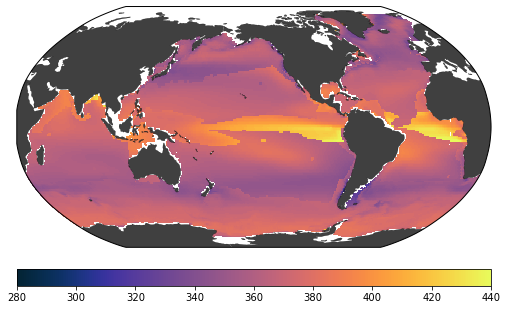

In [69]:
### Mask
dia = SpatialMap(cbar_location='bottom', cbar_orientation='horizontal')
sub = dia.add_plot(lon=ds_out['lon'], 
             lat=ds_out['lat'], 
             data=ds_out['spco2'].mean('time'), 
             ax=0, 
             cmap=cm.cm.thermal, 
             vrange=[280,440])
dia.add_colorbar(sub)
#plt.pcolor(ds_out['lon'], ds['lat'], ds_out['spco2'].mean('time'), vmin=280, vmax=440, cmap=cm.cm.thermal)
#plt.colorbar()

## plot biomes

In [50]:
ds_fay = group_fay_mckinley_biomes()

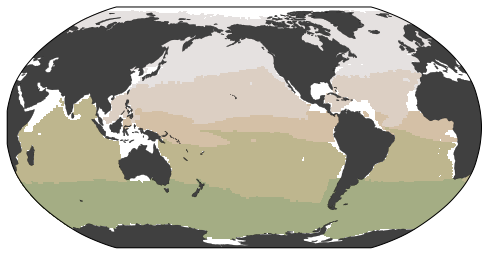

In [64]:
### Mask
dia = SpatialMap(colorbar=False)
dia.add_plot(lon=ds_fay['lon'], 
             lat=ds_fay['lat'], 
             data=ds_fay['MeanBiomesGrouped'], 
             ax=0, 
             cmap=cm.cm.rain, 
             vrange=[0,17])

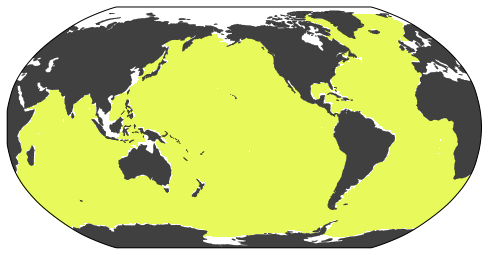

In [47]:
### Mask
dia = SpatialMap(colorbar=False)
dia.add_plot(lon=mask['lon'], 
             lat=mask['lat'], 
             data=mask, 
             ax=0, 
             cmap=cm.cm.thermal, 
             vrange=[0,1])

# Comparison at BATS

In [34]:
ds_bats = xr.open_dataset('/local/data/artemis/workspace/gloege/data/BATS/BATS.nc')

/home/gloege/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


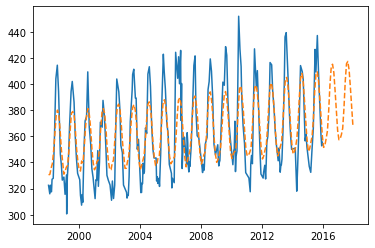

In [39]:
plt.plot(ds_bats['time'].sel(time=slice('1998-01-01','2017-12-31')), 
         ds_bats['spco2'].sel(time=slice('1998-01-01','2017-12-31')))
plt.plot(ds_out['time'], ds_out['spco2'].sel(lon=360-64, lat=32, method='nearest'),'--')

In [ ]:
rmse = mean_squared_error(y_test_ready, pred_test) ** 0.5
r, p = scipy.stats.pearsonr(np.expand_dims(y_test_ready, axis=1), pred_test)
print(f'RMSE = {rmse} uatm')
print(f'r = {r}')
print(f'R2 = {r**2}')
print(f'p-value = {p}')

# Comparison at HOT

In [36]:
ds_hot = xr.open_dataset('/local/data/artemis/workspace/gloege/data/HOT/HOT.nc')

In [37]:
ds_hot = ds_hot.where(ds_hot['spco2']>0)

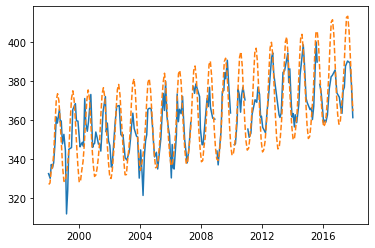

In [42]:
plt.plot(ds_hot['time'].sel(time=slice('1998-01-01','2017-12-31')), 
         ds_hot['spco2'].sel(time=slice('1998-01-01','2017-12-31')))
plt.plot(ds_out['time'], ds_out['spco2'].sel(lon=360-158, lat=22.75, method='nearest'),'--')

# Saving the model

In [46]:
model.save('./saved_model.h5')
#del model
#model = keras.models.load_model('path_to_my_model.h5')

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_v1 (Batc multiple                  60        
_________________________________________________________________
dense (Dense)                multiple                  16384     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  524800    
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  513       
Total params: 541,757
Trainable params: 541,727
Non-trainable params: 30
_________________________________________________________________


In [42]:
config = model.get_config()
weights = model.get_weights()

list